In [1]:
from fermi_sim import *
from encoding import *
from encoding import _single_site_op, _vertex_to_ordered_index, _odd_face_to_ordered_index
from Hamiltonian_topo import *
from scipy import *
import scipy.sparse.linalg
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

In [2]:
I = sparse.csr_matrix([[ 1,   0], [ 0,   1]], dtype=complex)
X = sparse.csr_matrix([[ 0,   1], [ 1,   0]], dtype=complex)
Y = sparse.csr_matrix([[ 0, -1j], [ 1j,  0]], dtype=complex)
Z = sparse.csr_matrix([[ 1,   0], [ 0,  -1]], dtype=complex)

lattsize = (4,4)
nqubits = num_qubits_encoding(lattsize)

verts = [(0, 1), (1, 1), (1, 2), (0, 2)]
R1 = sparse.identity(2**nqubits)
for v in verts:
    R1 = R1.dot(_single_site_op(Z, _vertex_to_ordered_index(lattsize, v), nqubits))
R1 = R1.dot(_single_site_op(X, _odd_face_to_ordered_index(lattsize, (0, 0)), nqubits))
R1 = R1.dot(_single_site_op(X, _odd_face_to_ordered_index(lattsize, (0, 2)), nqubits))
R1 = R1.dot(_single_site_op(Y, _odd_face_to_ordered_index(lattsize, (1, 1)), nqubits))

verts = [(1, 0), (1, 1), (2, 1), (2, 0)]
R2 = sparse.identity(2**nqubits)
for v in verts:
    R2 = R2.dot(_single_site_op(Z, _vertex_to_ordered_index(lattsize, v), nqubits))
R2 = R2.dot(_single_site_op(Y, _odd_face_to_ordered_index(lattsize, (0, 0)), nqubits))
R2 = R2.dot(_single_site_op(X, _odd_face_to_ordered_index(lattsize, (1, 1)), nqubits))
R2 = R2.dot(_single_site_op(Y, _odd_face_to_ordered_index(lattsize, (2, 0)), nqubits))

verts = [(1, 2), (2, 2), (1, 3), (2, 3)]
R3 = sparse.identity(2**nqubits)
for v in verts:
    R3 = R3.dot(_single_site_op(Z, _vertex_to_ordered_index(lattsize, v), nqubits))
R3 = R3.dot(_single_site_op(Y, _odd_face_to_ordered_index(lattsize, (0, 2)), nqubits))
R3 = R3.dot(_single_site_op(X, _odd_face_to_ordered_index(lattsize, (1, 1)), nqubits))
R3 = R3.dot(_single_site_op(Y, _odd_face_to_ordered_index(lattsize, (2, 2)), nqubits))

verts = [(2, 1), (2, 2), (3, 1), (3, 2)]
R4 = sparse.identity(2**nqubits)
for v in verts:
    R4 = R4.dot(_single_site_op(Z, _vertex_to_ordered_index(lattsize, v), nqubits))
R4 = R4.dot(_single_site_op(Y, _odd_face_to_ordered_index(lattsize, (1, 1)), nqubits))
R4 = R4.dot(_single_site_op(X, _odd_face_to_ordered_index(lattsize, (2, 0)), nqubits))
R4 = R4.dot(_single_site_op(X, _odd_face_to_ordered_index(lattsize, (2, 2)), nqubits))

assert spla.norm(comm(R1, R2)) == 0
assert spla.norm(comm(R3, R4)) == 0
assert spla.norm(comm(R1, R3)) == 0

In [3]:
ψ = np.kron(np.array([1., 1j]) / np.sqrt(2), np.array([1., 1j]) / np.sqrt(2))
ψ = np.kron(ψ, np.array([1., 1.]) / np.sqrt(2))
ψ = np.kron(ψ, np.array([1., 1j]) / np.sqrt(2))
ψ = np.kron(ψ, np.array([1., 1j]) / np.sqrt(2))

XXY = sparse.kron(sparse.kron(X,X),Y)
YXX = sparse.kron(sparse.kron(Y,X),X)

P1 = 0.5 * (sparse.identity(2**5) + sparse.kron(XXY, sparse.identity(4)))

P2 = 0.5 * (sparse.identity(2**5) + sparse.kron(sparse.identity(4), YXX))

ψ = np.sqrt(2) * P1.dot(ψ)
ψ = np.sqrt(2) * P2.dot(ψ)
ψ /= np.linalg.norm(ψ)

YIX = sparse.kron(sparse.kron(Y,I),X)
YIXY = sparse.kron(YIX,Y)
YIXYI = sparse.kron(YIXY,I)

IYX = sparse.kron(I,sparse.kron(Y,X))
IYXI = sparse.kron(IYX,I)
IYXIY = sparse.kron(IYXI,Y)

print(np.linalg.norm(sparse.kron(XXY, sparse.identity(4)).dot(ψ) - ψ) )
print(np.linalg.norm(sparse.kron(sparse.identity(4), YXX).dot(ψ) - ψ) )
print(np.linalg.norm(YIXYI.dot(ψ) - ψ) )
print(np.linalg.norm(IYXIY.dot(ψ) - ψ) )

0.0
0.0
0.0
0.0


In [4]:
def imaginary_time_evolution_show1(ψ, H, εmin, dτ, nsteps):

    nqubits = num_qubits_encoding(lattsize)
    
    for R in [R1, R2, R3, R4]:
        assert np.linalg.norm(R.dot(ψ) - ψ) < 1e-10
    
    ϵ_traj = np.zeros(nsteps)
    ϵ_traj[0] = np.vdot(ψ, H.dot(ψ)).real
    
    for n in range(1, nsteps):
        if n == nsteps//2:
            print('50% has been finished')
        ψ = spla.expm_multiply(-dτ*H, ψ)
        ψ /= np.linalg.norm(ψ)
        ϵ_traj[n] = np.vdot(ψ, H.dot(ψ)).real
        
    for R in [R1, R2, R3, R4]:
        assert np.linalg.norm(R.dot(ψ) - ψ) < 1e-10
        
    print(ϵ_traj[nsteps-1])
    
    plt.plot(dτ*np.arange(nsteps), ϵ_traj)
    plt.plot([0, nsteps*dτ], [ϵmin, ϵmin], "--")
    plt.xlabel("τ")
    plt.ylabel(r"$\langle \psi(\tau) | H | \psi(\tau) \rangle$")
    plt.title("imaginary time evolution: energy expectation")
    plt.show()
    # difference to ground state energy
    plt.semilogy(dτ*np.arange(nsteps), ϵ_traj - ϵmin)
    plt.ylabel(r"$\langle \psi(\tau) | H | \psi(\tau) \rangle - \epsilon_{\min}$")
    plt.title("imaginary time evolution: difference to exact ground state energy")
    plt.show()
    print("distance from the real ground:", ϵ_traj[nsteps-1] - ϵmin)
    
    return ϵ_traj[nsteps-1], ψ

In [5]:
H_ima_tar = H_Quad_topo((2,2), 0, 1) + sup_normal((2,2))
H_ima = H_Quad_encoded((2,2), 0, 1) + sup_encoded((2,2))

In [6]:
εmin, vmin = sparse.linalg.eigsh(H_ima_tar, which = 'SA', k = 1)

50% has been finished
-12.907074729959882


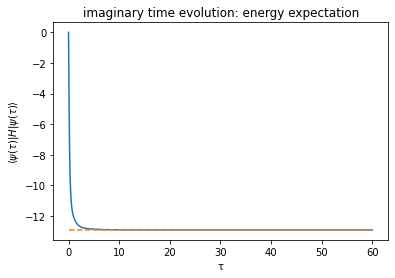

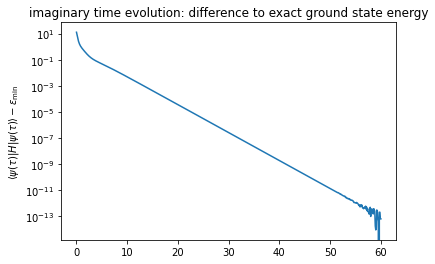

distance from the real ground: [6.21724894e-14]


In [7]:
ψz = np.zeros(2**16)
ψz[0] = 1 
ψ = np.kron(ψz, ψ)
εima = 0 
ψima = 0
εima, ψima = imaginary_time_evolution_show1(ψ, H_ima, εmin, 0.1, 601)

In [8]:
def adiabatic(H_initial, H_target, ϵ_tar, ψ_ini, dτ, nsteps):
     
    ϵ_traj = np.zeros(nsteps)
    ϵ_traj[0] = np.vdot(ψ_ini, H_target.dot(ψ_ini)).real
    ψ = ψ_ini    
    
    for R in [R1, R2, R3, R4]:
        assert np.linalg.norm(R.dot(ψ) - ψ) < 1e-10
    
    for n in range(1, nsteps):
        if n == nsteps//2:
            print('50% has been finished')
        s = n*(1/(nsteps-1))
        H = s*H_target + (1-s)*H_initial
        
        ψ = spla.expm_multiply(-(1j)*(dτ)*H, ψ)
        ψ /= np.linalg.norm(ψ)
        ϵ_traj[n] = np.vdot(ψ, H_target.dot(ψ)).real
        
    for R in [R1, R2, R3, R4]:
        assert np.linalg.norm(R.dot(ψ) - ψ) < 1e-10
        
    print(ϵ_traj[nsteps-1])
    
    plt.plot(dτ*np.arange(nsteps), ϵ_traj)
    
    plt.plot([0, nsteps*dτ], [ϵ_tar, ϵ_tar], "--")
    
    plt.xlabel("τ")
    plt.ylabel(r"$\langle \psi(\tau) | H_target | \psi(\tau) \rangle$")
    plt.title("adiabatic quantum computing: energy calculated by H_target")
    plt.show()
    
    plt.semilogy(dτ*np.arange(nsteps), ϵ_traj - ϵ_tar)
    plt.ylabel(r"$\langle \psi(\tau) | H_target | \psi(\tau) \rangle - \epsilon_{\min}$")
    plt.title("adiabatic quantum computing: difference to target state energy")
    plt.show()
    print("distance from the real ground:", ϵ_traj[nsteps-1] - ϵ_tar)
    #print("distance from the initial state:", ϵ_traj[nsteps-1] - εmin)
    
    
    return ϵ_traj[nsteps-1], ψ

In [9]:
H_target = H_Quad_encoded((2,2), 0, 1)
H_initial = H_ima
ϵ_tar, v_unencoded = sparse.linalg.eigsh(H_Quad_topo((2,2), 0, 1), which = 'SA', k = 1)

50% has been finished
-6.8245949983239385


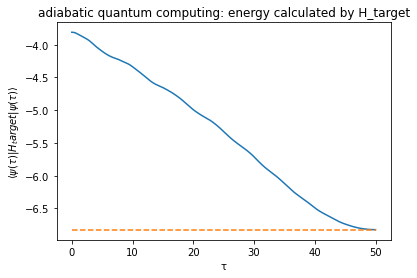

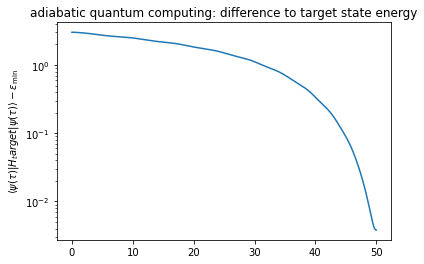

distance from the real ground: [0.00383213]


In [10]:
ϵ_adia, ψ_adia = adiabatic(H_initial, H_target, ϵ_tar, ψima, 0.1, 501)

In [ ]:
#ψ_adia is very close to the target state (ground state)
#so it is possible to use a imaginary again to get the groud state 

In [47]:
εmin1, vmin1 = sparse.linalg.eigsh(H_Quad_topo((2,2), 0, 1) + 0.1*sup_normal((2,2)), which = 'SA', k = 1)

50% has been finished
-6.916553425440197


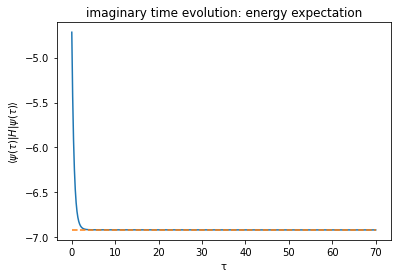

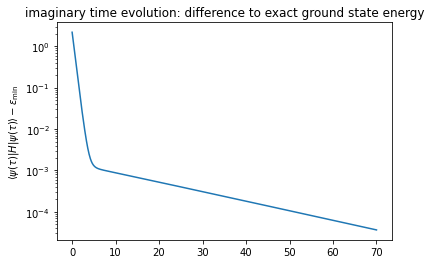

distance from the real ground: [3.65896093e-05]


In [51]:
εima1, ψima1 = imaginary_time_evolution_show1(ψima, H_target + 0.1*sup_encoded((2,2)), εmin1, 0.1, 701)

In [52]:
def imaginary_to_target(H_initial, H_target, ϵ_tar, ψ_ini, dτ, nsteps):
    
    ϵ_traj = np.zeros(nsteps)
    ϵ_traj[0] = np.vdot(ψ_ini, H_target.dot(ψ_ini)).real
    ψ = ψ_ini    
    
    for R in [R1, R2, R3, R4]:
        assert np.linalg.norm(R.dot(ψ) - ψ) < 1e-10
    
    for n in range(1, nsteps-2):
        if n == nsteps//2:
            print('50% has been finished')
        s = n*(1/(nsteps-1))
        H = s*H_target + (1-s)*H_initial
        
        ψ = spla.expm_multiply(-(dτ)*H, ψ)
        ψ /= np.linalg.norm(ψ)
        ϵ_traj[n] = np.vdot(ψ, H_target.dot(ψ)).real
        
    
    #for the last step, extend the evolving time.
    ψ = spla.expm_multiply(-(10)*H, ψ)
    ψ /= np.linalg.norm(ψ)
    ϵ_traj[nsteps-2] = np.vdot(ψ, H_target.dot(ψ)).real
    
    ψ = spla.expm_multiply(-(10)*H, ψ)
    ψ /= np.linalg.norm(ψ)
    ϵ_traj[nsteps-1] = np.vdot(ψ, H_target.dot(ψ)).real
    
    
    
        
    for R in [R1, R2, R3, R4]:
        assert np.linalg.norm(R.dot(ψ) - ψ) < 1e-10
        
    print(ϵ_traj[nsteps-1])
    
    plt.plot(dτ*np.arange(nsteps), ϵ_traj)
    
    plt.plot([0, nsteps*dτ], [ϵ_tar, ϵ_tar], "--")
    
    plt.xlabel("τ")
    plt.ylabel(r"$\langle \psi(\tau) | H_target | \psi(\tau) \rangle$")
    plt.title("adiabatic quantum computing: energy calculated by H_target")
    plt.show()
    
    plt.semilogy(dτ*np.arange(nsteps), ϵ_traj - ϵ_tar)
    plt.ylabel(r"$\langle \psi(\tau) | H_target | \psi(\tau) \rangle - \epsilon_{\min}$")
    plt.title("adiabatic quantum computing: difference to target state energy")
    plt.show()
    print("distance from the real ground:", ϵ_traj[nsteps-1] - ϵ_tar)
    #print("distance from the initial state:", ϵ_traj[nsteps-1] - εmin)
    
    
    return ϵ_traj[nsteps-1], ψ


50% has been finished
-6.828391788255411


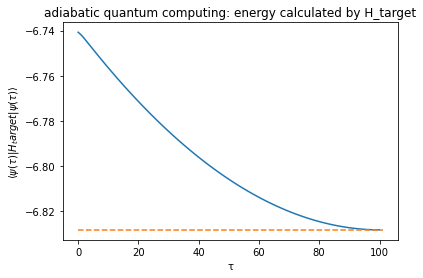

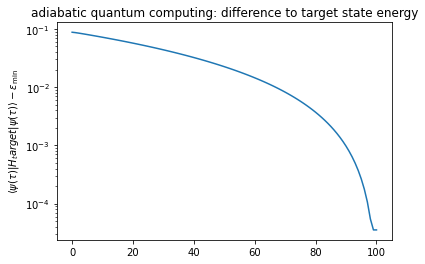

distance from the real ground: [3.53364908e-05]


In [53]:
ϵ_ima2, ψ_ima2 = imaginary_to_target(H_target + 0.1*sup_encoded((2,2)), H_target, ϵ_tar, ψima1, 1, 101)

In [21]:
#observe the protected corner state:
def quench(H_quench, v, dτ, nsteps, num_op):
    
    v /= np.linalg.norm(v)
    
    for R in [R1, R2, R3, R4]:
        assert np.linalg.norm(R.dot(v) - v) < 1e-10
    
    num_traj = np.zeros(nsteps)
    num_traj[0] = np.vdot((v), num_op.dot(v)).real
    print(num_traj[0])
    
    for n in range(1, nsteps):
        if n == nsteps//2:
            print('50% has been finished')
        v = spla.expm_multiply(-(1j)*(dτ)*H_quench, v)
        v /= np.linalg.norm(v)
        num_traj[n] = np.vdot((v), num_op.dot(v)).real
        
    for R in [R1, R2, R3, R4]:
        assert np.linalg.norm(R.dot(v) - v) < 1e-10
       
    plt.plot(dτ*np.arange(nsteps), num_traj)
    plt.show()
    

In [32]:
create_encoding_00 = construct_majorana_operator(lattsize, (0,0), MajoranaType.Re)
create_encoding_00 = create_encoding_00 - 1j*construct_majorana_operator(lattsize, (0,0), MajoranaType.Im)
create_encoding_00 /= 2 
ψ_quench = create_encoding_00.dot(ψ_adia)
num_op_0 = number_op(21,2**20)
H_quench = H_Quad_encoded((2,2), 0.1, 1)

0.9999999999999994


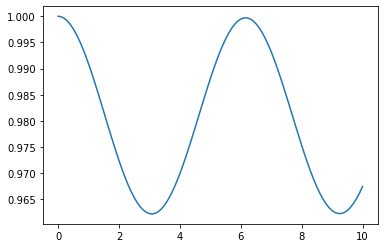

In [20]:
quench(H_quench, ψ_quench, 0.1, 101, num_op_0)

0.9999999999999994
50% has been finished


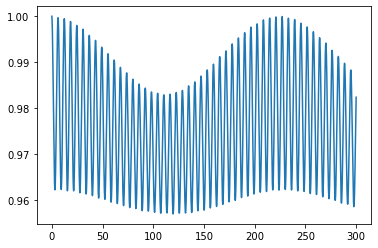

In [33]:
quench(H_quench, ψ_quench, 0.1, 3001, num_op_0)

In [22]:
create_encoding_11 = construct_majorana_operator(lattsize, (1,1), MajoranaType.Re)
create_encoding_11 = create_encoding_11 - 1j*construct_majorana_operator(lattsize, (1,1), MajoranaType.Im)
create_encoding_11 /= 2 
ψ_quench = create_encoding_11.dot(ψ_adia)
num_op_11 = number_op(21,2**15)

In [24]:
ψ_quench /= np.linalg.norm(ψ_quench)
np.vdot(ψ_quench, num_op_11.dot(ψ_quench))

(0.9999999999999981+0j)

0.9999999999999996
50% has been finished


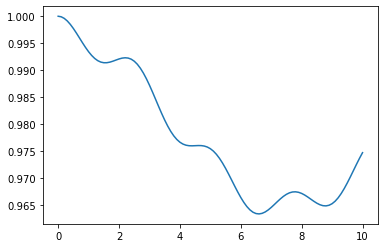

In [26]:
quench(H_quench, ψ_quench, 0.1, 101, num_op_11)

1.0000000000000002
50% has been finished


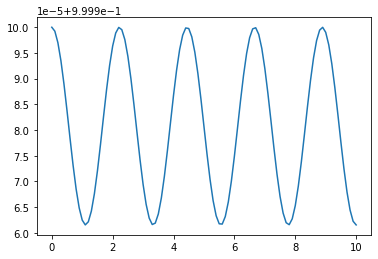

In [27]:
#turn-off the coupling
quench(H_Quad_encoded((2,2), 0, 1), ψ_quench, 0.1, 101, num_op_11)
#it keeps unchange because it (especially the four sites on the center) is eigenstate of H